# Garbage image classification

## Aggregating data, creating data set

We bring our folder images and we create a data frame.

In [2]:
import os
import pandas as pd

def list_folders_in_directory(directory):
    folders = [folder for folder in os.listdir(directory) if os.path.isdir(os.path.join(directory, folder))]
    return folders

directory_path = "./v1/Garbage classification/"
folders_list = list_folders_in_directory(directory_path)
print(folders_list)


['paper', 'metal', 'cardboard', 'trash', 'glass', 'plastic']


In [3]:
data = []
for folder in folders_list: 
    files = os.listdir(os.path.join(directory_path, folder))
    #Add each file along with its folder name to the data list
    for file in files:
        data.append({'Folder': folder, 'File_name': file})

# Create a DataFrame from the data list
df = pd.DataFrame(data)

# Display the DataFrame
df.head()



,Folder,File_name
0,paper,paper283.jpg
1,paper,paper297.jpg
2,paper,paper526.jpg
3,paper,paper240.jpg
4,paper,paper254.jpg


## Analising the data

First we are checking our data set to see how manny photos we have.

In [4]:
df.shape

(2527, 2)

We want to check how manny images we have in each category.

In [5]:
df['Folder'].value_counts()

Folder
paper        594
glass        501
plastic      482
metal        410
cardboard    403
trash        137
Name: count, dtype: int64

As we ca see, **trash** labes has verry few images , it is inbalance related to the rest of labels

We want to get more informations about our images
We can check the extensions.

We can see that we have only 'jpg' files.

In [6]:
# Extract extension using str.split and str.get
df['Extension'] = df['File_name'].str.split('.').str[-1]

df['Extension'].value_counts()

df.drop(df[df['Extension']=='DS_Store'].index , inplace=True)
df.head()

,Folder,File_name,Extension
0,paper,paper283.jpg,jpg
1,paper,paper297.jpg,jpg
2,paper,paper526.jpg,jpg
3,paper,paper240.jpg,jpg
4,paper,paper254.jpg,jpg


We want to check the dimension of images and the format type.

We are adding the dimensions of the image into the dataframe with the help of Pillow library

In [7]:
from PIL import Image

def get_image_dimensions(df_row):
    file_path = os.path.join(directory_path, df_row['Folder'], df_row['File_name'])
    image = Image.open(file_path)
    width, height = image.size
    return width, height, image.format

df['Image_width'], df['Image_height'], df['Format'] = zip(*df.apply(get_image_dimensions, axis=1))

df.head()

,Folder,File_name,Extension,Image_width,Image_height,Format
0,paper,paper283.jpg,jpg,512,384,JPEG
1,paper,paper297.jpg,jpg,512,384,JPEG
2,paper,paper526.jpg,jpg,512,384,JPEG
3,paper,paper240.jpg,jpg,512,384,JPEG
4,paper,paper254.jpg,jpg,512,384,JPEG


We are checking how many different values we have in those two columns.

It seems that all the files have the same size. This means that we do not need to do any transformation to the size of the files.

In [8]:
print(df.Image_width.value_counts())
print(30*'*')
print(df.Image_height.value_counts())

Image_width
512    2527
Name: count, dtype: int64
******************************
Image_height
384    2527
Name: count, dtype: int64


We can also take a look at the files format type.
We can see that all images have **JPEG** format

In [9]:
df['Format'].value_counts()

Format
JPEG    2527
Name: count, dtype: int64

## Data processing

We need to load the data to normalise it, and split the data in training dataset and validation dataset.

In [10]:
import tensorflow as tf
# Define image parameters

image_width = 250
image_height = 250
batch_size = 32


# Create a TensorFlow Dataset object
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory_path,
    labels="inferred",  # Labels are inferred from subfolder names
    label_mode="categorical",  # Use integer labels
    color_mode="rgb",
    image_size=(image_width, image_height),
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="training"
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory_path,
    labels="inferred",  # Labels are inferred from subfolder names
    label_mode="categorical",  # Use integer labels
    color_mode="rgb",
    image_size=(image_width, image_height),
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation"
)




2024-03-19 10:54:30.093000: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 2527 files belonging to 6 classes.
Using 2022 files for training.


2024-03-19 10:54:40.188401: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 2527 files belonging to 6 classes.
Using 505 files for validation.


Here we can see that we created a dataset with 6 classes

In [48]:
class_names = train_dataset.class_names
print("Class names:", class_names)


Class names: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


Data visualisation of 5 images from each class

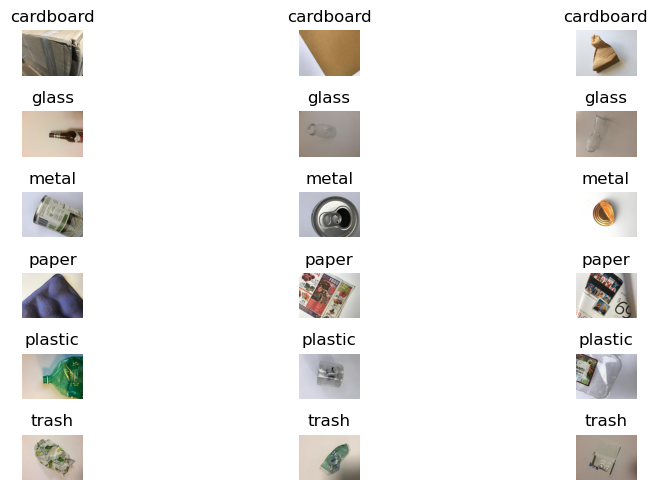

In [50]:
import os
import matplotlib.pyplot as plt
from PIL import Image

#class_names = [name for name in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, name))]

plt.figure(figsize=(10, 5))

num_images_per_class = 3

for class_index, class_name in enumerate(class_names):
    class_images = []
    class_path = os.path.join(directory_path, class_name)
    for img_name in os.listdir(class_path)[:num_images_per_class]:
        if img_name != ".DS_Store":  # Skip non-directory files
            img_path = os.path.join(class_path, img_name)
            image = Image.open(img_path)
            class_images.append(image)
    
    for k in range(num_images_per_class):
        if k < len(class_images):
            plt.subplot(len(class_names), num_images_per_class, class_index * num_images_per_class + k + 1)
            plt.imshow(class_images[k])
            plt.title(class_name)
            plt.axis("off")

plt.tight_layout()
plt.show()


We take a look on what we have in train data set, and we can observe that we have a 32 batch size, the size of images are the ones that we provided, and we also have the labels

In [13]:
for images, labels in train_dataset:
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)
    print("Label batch type:", labels.dtype)
    break  # Print only the first batch

Image batch shape: (32, 250, 250, 3)
Label batch shape: (32, 6)
Label batch type: <dtype: 'float32'>


Now we need to normalise the data
We can normalize the data by splitting the value of the pixels with 255, because the range of the values of the pixels are between 0 and 255 and we will get values between 0 an 1

In [14]:
normalization_layer = tf.keras.layers.Rescaling(scale = 1./255)

normalized_train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
normalized_val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))

for images, labels in normalized_train_dataset:
    print("Image batch shape after normalization:", images)
    print("Label batch shape after normalization:", labels)
    print("Label batch type:", labels.dtype)
    break  # Print only the first batch


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Image batch shape after normalization: tf.Tensor(
[[[[0.7121743  0.64550763 0.6141351 ]
   [0.7104052  0.6437385  0.6045228 ]
   [0.71328634 0.6466197  0.60740393]
   ...
   [0.63420326 0.5008699  0.39106598]
   [0.6313726  0.49803925 0.38823533]
   [0.63379    0.50045663 0.39065272]]

  [[0.7016314  0.63496476 0.6035922 ]
   [0.7138506  0.6471839  0.6079682 ]
   [0.720508   0.6538413  0.61462563]
   ...
   [0.6372489  0.50391555 0.3941116 ]
   [0.6327221  0.49938872 0.38958478]
   [0.63529414 0.5019608  0.3921569 ]]

  [[0.69430596 0.6276393  0.59626675]
   [0.71653336 0.6498667  0.610651  ]
   [0.7254902  0.65882355 0.61960787]
   ...
   [0.6382321  0.5048988  0.39509484]
   [0.63529414 0.5019608  0.3921569 ]
   [0.6378595  0.5045262  0.39472225]]

  ...

  [[0.9617928  0.79521173 0.65208167]
   [0.9240276  0.7605079  0.6185964 ]
   [0.9124345  0.7631011  0.62192464]
   ...
   [0.48867598 0.40781337 0.301931  ]
   [0.48368794 0.41089013 0.2893155 ]
   [0.5063004  0.44355536 0.3122768

## Define the model

Now that we have our data normalized we need to define the convolutional model


In [15]:
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam

# Define the convolutional neural network architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, 3)),  # Input
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(6, activation='softmax')  # 6 classes
])


After we created the model now we can compile it

In [16]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


We can take a look on the model summary

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 124, 124, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 59, 59, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 222784)            0

We train the model

In [17]:

epochs = 10
history = model.fit(normalized_train_dataset, validation_data = normalized_val_dataset, epochs=epochs)

Epoch 1/10


64/64 [==============================] - 159s 2s/step - loss: 2.0570 - accuracy: 0.1968 - val_loss: 1.7120 - val_accuracy: 0.2376
Epoch 2/10
64/64 [==============================] - 157s 2s/step - loss: 1.6613 - accuracy: 0.2913 - val_loss: 1.6274 - val_accuracy: 0.2673
Epoch 3/10
64/64 [==============================] - 158s 2s/step - loss: 1.5294 - accuracy: 0.3823 - val_loss: 1.5259 - val_accuracy: 0.3941
Epoch 4/10
64/64 [==============================] - 169s 3s/step - loss: 1.3755 - accuracy: 0.4580 - val_loss: 1.4904 - val_accuracy: 0.3762
Epoch 5/10
64/64 [==============================] - 100s 2s/step - loss: 1.1482 - accuracy: 0.5593 - val_loss: 1.5465 - val_accuracy: 0.4198
Epoch 6/10
64/64 [==============================] - 93s 1s/step - loss: 0.9538 - accuracy: 0.6370 - val_loss: 1.6015 - val_accuracy: 0.4653
Epoch 7/10
64/64 [==============================] - 92s 1s/step - loss: 0.7550 - accuracy: 0.7245 - val_loss: 2.0922 - val_accuracy: 0.3941
Epoch 8/10
64/64 [========

Here we take a look on the model metrics on loss and accuracy
We an define a method to plot the validation and accuraci, to reuse it.

In [18]:
def plot_validation_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

We can see that accuraci is increasing but validation accuraci is dropping after a while and remains under 40%
This means that our model is not performing well, what we can try next is to use data augumentation or add more images.

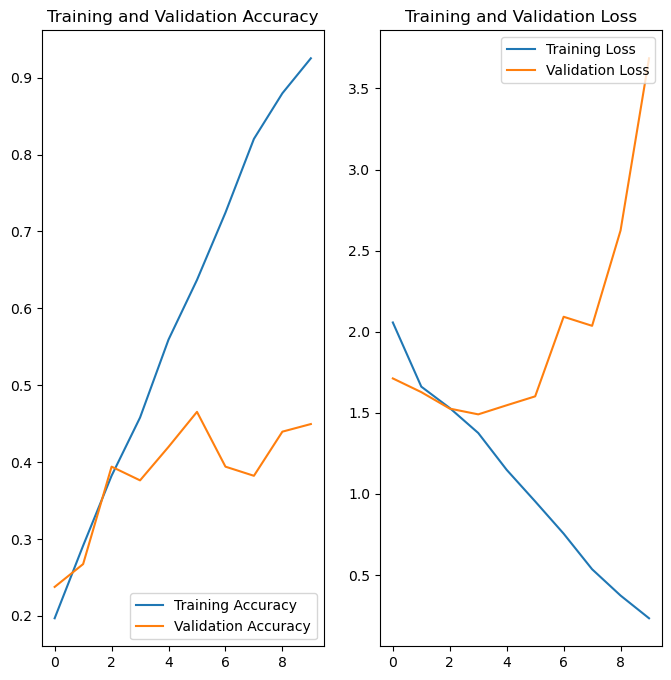

In [19]:
plot_validation_training(history)

## Data augumentation

We will use image data generator method , to generate images in our training process.

In [20]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,
                                   rotation_range=15,zoom_range=0.1,
                                   width_shift_range=0.15,height_shift_range=0.15,
                                   shear_range=0.1,
                                   fill_mode="nearest",
                                   rescale=1./255.,
                                   validation_split=0.2)

train_generator = train_datagen.flow_from_directory(directory_path, target_size=(image_width, image_height), batch_size=32, class_mode="categorical", subset='training')
validation_generator = train_datagen.flow_from_directory(directory_path, target_size=(image_width, image_height), batch_size=32,class_mode="categorical", subset='validation')

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


Now we will create another model to check out how it will behave with data generator

In [22]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam

# Define the convolutional neural network architecture
aug_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, 3)),  # Input
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(6, activation='softmax')  # 6 classes
])

In [23]:
aug_model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
epochs = 10
history_aug = aug_model.fit(train_generator, validation_data = validation_generator, epochs=epochs)

Epoch 1/10
64/64 [==============================] - 107s 2s/step - loss: 2.0621 - accuracy: 0.3058 - val_loss: 1.6130 - val_accuracy: 0.3062
Epoch 2/10
64/64 [==============================] - 102s 2s/step - loss: 1.4795 - accuracy: 0.3696 - val_loss: 1.5821 - val_accuracy: 0.3260
Epoch 3/10
64/64 [==============================] - 108s 2s/step - loss: 1.3953 - accuracy: 0.4175 - val_loss: 1.4808 - val_accuracy: 0.3956
Epoch 4/10
64/64 [==============================] - 104s 2s/step - loss: 1.2884 - accuracy: 0.4822 - val_loss: 1.4609 - val_accuracy: 0.3956
Epoch 5/10
64/64 [==============================] - 105s 2s/step - loss: 1.2618 - accuracy: 0.5128 - val_loss: 1.4173 - val_accuracy: 0.4374
Epoch 6/10
64/64 [==============================] - 103s 2s/step - loss: 1.2181 - accuracy: 0.5227 - val_loss: 1.3906 - val_accuracy: 0.4672
Epoch 7/10
64/64 [==============================] - 103s 2s/step - loss: 1.2237 - accuracy: 0.5371 - val_loss: 1.5318 - val_accuracy: 0.3777
Epoch 8/10
64

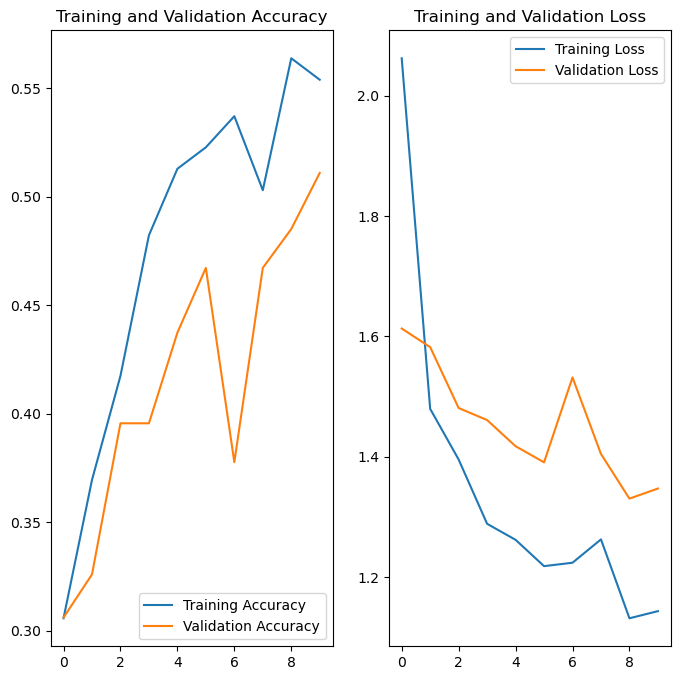

In [25]:
plot_validation_training(history_aug)

We will train for more 50 epochs because our model is still at a low accuracy

In [30]:
epochs = 50
history_aug_1 = aug_model.fit(train_generator, validation_data = validation_generator, epochs=epochs)

Epoch 1/20
64/64 [==============================] - 90s 1s/step - loss: 0.5959 - accuracy: 0.7866 - val_loss: 1.0895 - val_accuracy: 0.6044
Epoch 2/20
64/64 [==============================] - 81s 1s/step - loss: 0.6371 - accuracy: 0.7717 - val_loss: 1.1116 - val_accuracy: 0.6322
Epoch 3/20
64/64 [==============================] - 81s 1s/step - loss: 0.6925 - accuracy: 0.7441 - val_loss: 1.0138 - val_accuracy: 0.6402
Epoch 4/20
64/64 [==============================] - 81s 1s/step - loss: 0.6091 - accuracy: 0.7831 - val_loss: 1.0978 - val_accuracy: 0.6342
Epoch 5/20
64/64 [==============================] - 89s 1s/step - loss: 0.6054 - accuracy: 0.7885 - val_loss: 1.0417 - val_accuracy: 0.6600
Epoch 6/20
64/64 [==============================] - 86s 1s/step - loss: 0.5885 - accuracy: 0.7900 - val_loss: 1.2141 - val_accuracy: 0.6223
Epoch 7/20
64/64 [==============================] - 83s 1s/step - loss: 0.5843 - accuracy: 0.7856 - val_loss: 1.0750 - val_accuracy: 0.6103
Epoch 8/20
64/64 [==

Let's evaluate our model

In [55]:
# Evaluate the model
test_loss, test_accuracy = aug_model.evaluate(validation_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

16/16 [==============================] - 12s 741ms/step - loss: 1.2882 - accuracy: 0.5984
Test Loss: 1.2881542444229126
Test Accuracy: 0.5984095335006714


We noticed that our model does not reach a good accuracy after 60 epoch's , we could let him train for more epoch's but the training it will take to much time.

Now let's try to make a prediction with an image

Image loaded successfully as a TensorFlow tensor.
1/1 [==============================] - 0s 51ms/step


trash
0.42485228
[[0.39857328 0.08069193 0.02211097 0.0396301  0.03414134 0.42485228]]


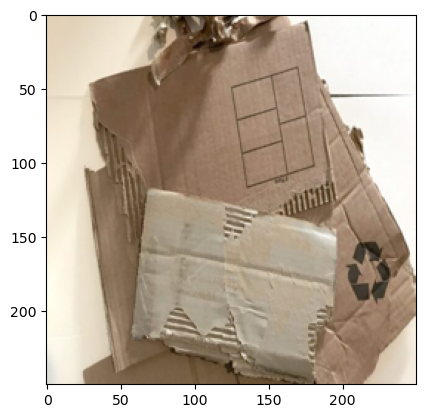

In [52]:
import numpy as np

image = Image.open('/Users/admin/Desktop/2-copy-3-scaled-600x400.jpg')

# Resize the image to the desired size
image = image.resize((250, 250))  # Replace 'width' and 'height' with desired dimensions

# Convert the image to a numpy array
image_array = np.array(image)

# Convert the numpy array to a TensorFlow tensor
image_tensor = tf.convert_to_tensor(image_array, dtype=tf.float32) / 255.0

# Expand the dimensions of the tensor to match the expected input shape
image_tensor = tf.expand_dims(image_tensor, axis=0)

print("Image loaded successfully as a TensorFlow tensor.")

predictions = aug_model.predict(image_tensor)
predicted_index = np.argmax(predictions)
predicted_label = class_names[predicted_index]
print(predicted_label)
print(np.max(predictions))
plt.imshow(image)
print(predictions)


In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

data_directory = "validation_images"

#model = tf.keras.models.load_model('models/first_model_1.h5')


class_names = [name for name in os.listdir(data_directory) if os.path.isdir(os.path.join(data_directory, name))]

plt.figure(figsize=(10, 10))

num_images_per_class = 6

for class_index, class_name in enumerate(class_names):
    class_images = []
    class_predictions =[]
    class_accuracy =[]
    class_path = os.path.join(data_directory, class_name)
    for img_name in os.listdir(class_path)[:num_images_per_class]:
        if img_name != ".DS_Store":  # Skip non-directory files
            img_path = os.path.join(class_path, img_name)
            image = Image.open(img_path)

            image = image.resize((250, 250))  # Replace 'width' and 'height' with desired dimensions

            # Convert the image to a numpy array
            image_array = np.array(image)

            # Convert the numpy array to a TensorFlow tensor
            image_tensor = tf.convert_to_tensor(image_array, dtype=tf.float32) / 255.0

            # Expand the dimensions of the tensor to match the expected input shape
            image_tensor = tf.expand_dims(image_tensor, axis=0)
            
            predictions = model.predict(image_tensor)
            predicted_index = np.argmax(predictions)
            predicted_label = class_names[predicted_index]
            accuracy = np.round(np.max(predictions), 2)
            class_images.append(image)
            class_predictions.append("\nPred: "+ predicted_label)
            class_accuracy.append(f"\nAcc: {accuracy:.2f}")
    
    for k in range(num_images_per_class):
        if k < len(class_images):
            plt.subplot(len(class_names), num_images_per_class, class_index * num_images_per_class + k + 1)
            plt.imshow(class_images[k])
            plt.title(class_name + class_predictions[k] + class_accuracy[k])
            plt.axis("off")

plt.tight_layout()
plt.show()